In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# import torch
%cd Mlabs File Storage/Final Year Project/pose

/content/drive/My Drive/Mlabs File Storage/Final Year Project/pose


In [2]:
!pwd
!ls
%cd drive/My Drive/Mlabs File Storage/Final Year Project/pose
!pip install configobj
import csv

csvfile = open('persondata.csv', 'wb')
writer = csv.writer(csvfile)

/content
drive  sample_data
/content/drive/My Drive/Mlabs File Storage/Final Year Project/pose
  Stored in directory: /root/.cache/pip/wheels/f1/e4/16/4981ca97c2d65106b49861e0b35e2660695be7219a2d351ee0
Successfully built configobj


In [0]:
import numpy as np
import tensorflow as tf
import cv2
import time
import os

def area(p1, p2, p3): 
    x1=p1[0]
    y1=p1[1]
    x2=p2[0]
    y2=p2[1]
    x3=p3[0]
    y3=p3[1]
    return abs((x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2)) / 2.0) 

def check(p1, p2, p3, p4, p): 
    
    
    # Calculate area of rectangle ABCD  
    A = (area(p1, p2, p3) + area(p1, p4, p3)) 

    # Calculate area of triangle PAB  
    A1 = area(p, p1, p2) 

    # Calculate area of triangle PBC  
    A2 = area(p, p2, p3) 

    # Calculate area of triangle PCD  
    A3 = area(p, p3, p4) 

    # Calculate area of triangle PAD  
    A4 = area(p, p1, p4); 

    # Check if sum of A1, A2, A3  
    # and A4 is same as A  
    return (A == A1 + A2 + A3 + A4) 

def overlap(boxA,boxB):
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])
  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
  boxA_Area = abs(boxA[0]-boxA[2])*abs(boxA[1]-boxA[3])
  boxB_Area = abs(boxB[0]-boxB[2])*abs(boxB[1]-boxB[3])
  min_Area = min(boxA_Area,boxB_Area)
  if interArea/min_Area < 0.3:
    return [1,'ab']
  else:
    if min_Area==boxA_Area:
      return [0,'b']
    else:
      return [0,'a']
  
class DetectorAPI:
    def __init__(self, path_to_ckpt):
        self.path_to_ckpt = path_to_ckpt

        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(self.path_to_ckpt, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')

        self.default_graph = self.detection_graph.as_default()
        self.sess = tf.Session(graph=self.detection_graph)

        # Definite input and output Tensors for detection_graph
        self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        self.detection_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        self.detection_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
        self.detection_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
        self.num_detections = self.detection_graph.get_tensor_by_name('num_detections:0')

    def processFrame(self, image):
        # Expand dimensions since the trained_model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image, axis=0)
        # Actual detection.
        start_time = time.time()
        (boxes, scores, classes, num) = self.sess.run(
            [self.detection_boxes, self.detection_scores, self.detection_classes, self.num_detections],
            feed_dict={self.image_tensor: image_np_expanded})
        end_time = time.time()

        print("Elapsed Time:", end_time-start_time)

        im_height, im_width,_ = image.shape
        boxes_list = [None for i in range(boxes.shape[1])]
        for i in range(boxes.shape[1]):
            boxes_list[i] = (int(boxes[0,i,0] * im_height),
                        int(boxes[0,i,1]*im_width),
                        int(boxes[0,i,2] * im_height),
                        int(boxes[0,i,3]*im_width))

        return boxes_list, scores[0].tolist(), [int(x) for x in classes[0].tolist()], int(num[0])

    def close(self):
        self.sess.close()
        self.default_graph.close()

model_path = './person_detection/faster_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'
odapi = DetectorAPI(path_to_ckpt=model_path)

In [0]:
import os
import re
import sys
import cv2
import math
import time
import scipy
import argparse
import matplotlib
# from torch import np
import pylab as plt
from joblib import Parallel, delayed
import util
import torch
import torch as T
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from config_reader import config_reader
from scipy.ndimage.filters import gaussian_filter
import pickle
#parser = argparse.ArgumentParser()
#parser.add_argument('--t7_file', required=True)
#parser.add_argument('--pth_file', required=True)
#args = parser.parse_args()
torch.set_num_threads(torch.get_num_threads())
weight_name = './model/pose_model.pth'
blocks = {}
# find connection in the specified sequence, center 29 is in the position 15
limbSeq = [[2,3], [2,6], [3,4], [4,5], [6,7], [7,8], [2,9], [9,10], \
           [10,11], [2,12], [12,13], [13,14], [2,1], [1,15], [15,17], \
           [1,16], [16,18], [3,17], [6,18]]
# the middle joints heatmap correpondence
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], [19,20], [21,22], \
          [23,24], [25,26], [27,28], [29,30], [47,48], [49,50], [53,54], [51,52], \
          [55,56], [37,38], [45,46]]
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]        
block0  = [{'conv1_1':[3,64,3,1,1]},{'conv1_2':[64,64,3,1,1]},{'pool1_stage1':[2,2,0]},{'conv2_1':[64,128,3,1,1]},{'conv2_2':[128,128,3,1,1]},{'pool2_stage1':[2,2,0]},{'conv3_1':[128,256,3,1,1]},{'conv3_2':[256,256,3,1,1]},{'conv3_3':[256,256,3,1,1]},{'conv3_4':[256,256,3,1,1]},{'pool3_stage1':[2,2,0]},{'conv4_1':[256,512,3,1,1]},{'conv4_2':[512,512,3,1,1]},{'conv4_3_CPM':[512,256,3,1,1]},{'conv4_4_CPM':[256,128,3,1,1]}]
blocks['block1_1']  = [{'conv5_1_CPM_L1':[128,128,3,1,1]},{'conv5_2_CPM_L1':[128,128,3,1,1]},{'conv5_3_CPM_L1':[128,128,3,1,1]},{'conv5_4_CPM_L1':[128,512,1,1,0]},{'conv5_5_CPM_L1':[512,38,1,1,0]}]
blocks['block1_2']  = [{'conv5_1_CPM_L2':[128,128,3,1,1]},{'conv5_2_CPM_L2':[128,128,3,1,1]},{'conv5_3_CPM_L2':[128,128,3,1,1]},{'conv5_4_CPM_L2':[128,512,1,1,0]},{'conv5_5_CPM_L2':[512,19,1,1,0]}]

for i in range(2,7):
    blocks['block%d_1'%i]  = [{'Mconv1_stage%d_L1'%i:[185,128,7,1,3]},{'Mconv2_stage%d_L1'%i:[128,128,7,1,3]},{'Mconv3_stage%d_L1'%i:[128,128,7,1,3]},{'Mconv4_stage%d_L1'%i:[128,128,7,1,3]},
{'Mconv5_stage%d_L1'%i:[128,128,7,1,3]},{'Mconv6_stage%d_L1'%i:[128,128,1,1,0]},{'Mconv7_stage%d_L1'%i:[128,38,1,1,0]}]
    blocks['block%d_2'%i]  = [{'Mconv1_stage%d_L2'%i:[185,128,7,1,3]},{'Mconv2_stage%d_L2'%i:[128,128,7,1,3]},{'Mconv3_stage%d_L2'%i:[128,128,7,1,3]},{'Mconv4_stage%d_L2'%i:[128,128,7,1,3]},
{'Mconv5_stage%d_L2'%i:[128,128,7,1,3]},{'Mconv6_stage%d_L2'%i:[128,128,1,1,0]},{'Mconv7_stage%d_L2'%i:[128,19,1,1,0]}]

def make_layers(cfg_dict):
    layers = []
    for i in range(len(cfg_dict)-1):
        one_ = cfg_dict[i]
        for k,v in one_.iteritems():      
            if 'pool' in k:
                layers += [nn.MaxPool2d(kernel_size=v[0], stride=v[1], padding=v[2] )]
            else:
                conv2d = nn.Conv2d(in_channels=v[0], out_channels=v[1], kernel_size=v[2], stride = v[3], padding=v[4])
                layers += [conv2d, nn.ReLU(inplace=True)]
    one_ = cfg_dict[-1].keys()
    k = one_[0]
    v = cfg_dict[-1][k]
    conv2d = nn.Conv2d(in_channels=v[0], out_channels=v[1], kernel_size=v[2], stride = v[3], padding=v[4])
    layers += [conv2d]
    return nn.Sequential(*layers)
    
layers = []
for i in range(len(block0)):
    one_ = block0[i]
    for k,v in one_.iteritems():      
        if 'pool' in k:
            layers += [nn.MaxPool2d(kernel_size=v[0], stride=v[1], padding=v[2] )]
        else:
            conv2d = nn.Conv2d(in_channels=v[0], out_channels=v[1], kernel_size=v[2], stride = v[3], padding=v[4])
            layers += [conv2d, nn.ReLU(inplace=True)]  
models = {}           
models['block0']=nn.Sequential(*layers)        

for k,v in blocks.iteritems():
    models[k] = make_layers(v)
                
class pose_model(nn.Module):
    def __init__(self,model_dict,transform_input=False):
        super(pose_model, self).__init__()
        self.model0   = model_dict['block0']
        self.model1_1 = model_dict['block1_1']        
        self.model2_1 = model_dict['block2_1']  
        self.model3_1 = model_dict['block3_1']  
        self.model4_1 = model_dict['block4_1']  
        self.model5_1 = model_dict['block5_1']  
        self.model6_1 = model_dict['block6_1']  
        self.model1_2 = model_dict['block1_2']        
        self.model2_2 = model_dict['block2_2']  
        self.model3_2 = model_dict['block3_2']  
        self.model4_2 = model_dict['block4_2']  
        self.model5_2 = model_dict['block5_2']  
        self.model6_2 = model_dict['block6_2']
        
    def forward(self, x):    
        out1 = self.model0(x)
        out1_1 = self.model1_1(out1)
        out1_2 = self.model1_2(out1)
        out2  = torch.cat([out1_1,out1_2,out1],1)
        out2_1 = self.model2_1(out2)
        out2_2 = self.model2_2(out2)
        out3   = torch.cat([out2_1,out2_2,out1],1)
        out3_1 = self.model3_1(out3)
        out3_2 = self.model3_2(out3)
        out4   = torch.cat([out3_1,out3_2,out1],1)
        out4_1 = self.model4_1(out4)
        out4_2 = self.model4_2(out4)
        out5   = torch.cat([out4_1,out4_2,out1],1)  
        out5_1 = self.model5_1(out5)
        out5_2 = self.model5_2(out5)
        out6   = torch.cat([out5_1,out5_2,out1],1)          
        out6_1 = self.model6_1(out6)
        out6_2 = self.model6_2(out6)
        return out6_1,out6_2        


model = pose_model(models)     
model.load_state_dict(torch.load(weight_name))
model.cuda()
model.float()
model.eval()

param_, model_ = config_reader()
personmapper=[]
pm1=[]
#torch.nn.functional.pad(img pad, mode='constant', value=model_['padValue'])
for file1 in sorted(os.listdir("../newdata/frames")):
  try:
    tic = time.time()
    test_image = '../newdata/frames/'+file1
    #     test_image = '../frames/576.jpg'
    #test_image = 'a.jpg'
    oriImg = cv2.imread(test_image) # B,G,R order
    imageToTest = Variable(T.transpose(T.transpose(T.unsqueeze(torch.from_numpy(oriImg).float(),0),2,3),1,2),volatile=True).cuda()
    # oriImg = cv2.resize(oriImg,(1024,768))
    imoverlay = oriImg
    multiplier = [x * model_['boxsize'] / oriImg.shape[0] for x in param_['scale_search']]

    heatmap_avg = torch.zeros((len(multiplier),19,oriImg.shape[0], oriImg.shape[1])).cuda()
    paf_avg = torch.zeros((len(multiplier),38,oriImg.shape[0], oriImg.shape[1])).cuda()
    #print heatmap_avg.size()

    toc =time.time()
    print 'time is %.5f'%(toc-tic) 
    tic = time.time()
    for m in range(len(multiplier)):
        scale = multiplier[m]
        h = int(oriImg.shape[0]*scale)
        w = int(oriImg.shape[1]*scale)
        pad_h = 0 if (h%model_['stride']==0) else model_['stride'] - (h % model_['stride']) 
        pad_w = 0 if (w%model_['stride']==0) else model_['stride'] - (w % model_['stride'])
        new_h = h+pad_h
        new_w = w+pad_w
        imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
        imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_['stride'], model_['padValue'])
        imageToTest_padded = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,2,0,1))/256 - 0.5  #check
        feed = Variable(T.from_numpy(imageToTest_padded)).cuda()      
        output1,output2 = model(feed)
    #         print output1.size()
    #         print output2.size()
        heatmap = nn.UpsamplingBilinear2d((oriImg.shape[0], oriImg.shape[1])).cuda()(output2)
        paf = nn.UpsamplingBilinear2d((oriImg.shape[0], oriImg.shape[1])).cuda()(output1)       
        heatmap_avg[m] = heatmap[0].data
        paf_avg[m] = paf[0].data  


    toc =time.time()
    #     print 'time is %.5f'%(toc-tic) 
    tic = time.time()

    heatmap_avg = T.transpose(T.transpose(T.squeeze(T.mean(heatmap_avg, 0)),0,1),1,2).cuda() 
    paf_avg     = T.transpose(T.transpose(T.squeeze(T.mean(paf_avg, 0)),0,1),1,2).cuda() 
    heatmap_avg=heatmap_avg.cpu().numpy()
    paf_avg    = paf_avg.cpu().numpy()
    toc =time.time()
    #     print 'time is %.5f'%(toc-tic) 
    tic = time.time()
    all_peaks = []
    peak_counter = 0 
    for part in range(18):
        map_ori = heatmap_avg[:,:,part]
        map = gaussian_filter(map_ori, sigma=3)
        map_left = np.zeros(map.shape)
        map_left[1:,:] = map[:-1,:]
        map_right = np.zeros(map.shape)
        map_right[:-1,:] = map[1:,:]
        map_up = np.zeros(map.shape)
        map_up[:,1:] = map[:,:-1]
        map_down = np.zeros(map.shape)
        map_down[:,:-1] = map[:,1:]
        peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > param_['thre1']))
    #    peaks_binary = T.eq(
    #    peaks = zip(T.nonzero(peaks_binary)[0],T.nonzero(peaks_binary)[0])
        peaks = zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]) # note reverse
        peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
        id = range(peak_counter, peak_counter + len(peaks))
        peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]
        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)
    # print(all_peaks)
    joints=[]
    for i in range(len(all_peaks)):
        l=[]
        for j in range(len(all_peaks[i])):
            l.append([all_peaks[i][j][0],all_peaks[i][j][1]])
        joints.append(l)
    # print(joints)
    connection_all = []
    special_k = []
    mid_num = 10
    for k in range(len(mapIdx)):
        score_mid = paf_avg[:,:,[x-19 for x in mapIdx[k]]]
        candA = all_peaks[limbSeq[k][0]-1]
        candB = all_peaks[limbSeq[k][1]-1]
        nA = len(candA)
        nB = len(candB)
        indexA, indexB = limbSeq[k]
        if(nA != 0 and nB != 0):
            connection_candidate = []
            for i in range(nA):
                for j in range(nB):
                    vec = np.subtract(candB[j][:2], candA[i][:2])
                    norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
                    vec = np.divide(vec, norm)

                    startend = zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                                   np.linspace(candA[i][1], candB[j][1], num=mid_num))
                    vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                      for I in range(len(startend))])
                    vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                      for I in range(len(startend))])
                    score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                    score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*oriImg.shape[0]/norm-1, 0)
                    criterion1 = len(np.nonzero(score_midpts > param_['thre2'])[0]) > 0.8 * len(score_midpts)
                    criterion2 = score_with_dist_prior > 0
                    if criterion1 and criterion2:
                        connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])
            connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
            connection = np.zeros((0,5))
            for c in range(len(connection_candidate)):
                i,j,s = connection_candidate[c][0:3]
                if(i not in connection[:,3] and j not in connection[:,4]):
                    connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                    if(len(connection) >= min(nA, nB)):
                        break
            connection_all.append(connection)
        else:
            special_k.append(k)
            connection_all.append([])
    # last number in each row is the total parts number of that person
    # the second last number in each row is the score of the overall configuration
    subset = -1 * np.ones((0, 20))
    candidate = np.array([item for sublist in all_peaks for item in sublist])

    for k in range(len(mapIdx)):
        if k not in special_k:
            partAs = connection_all[k][:,0]
            partBs = connection_all[k][:,1]
            indexA, indexB = np.array(limbSeq[k]) - 1
            for i in range(len(connection_all[k])): #= 1:size(temp,1)
                found = 0
                subset_idx = [-1, -1]
                for j in range(len(subset)): #1:size(subset,1):
                    if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                        subset_idx[found] = j
                        found += 1
                if found == 1:
                    j = subset_idx[0]
                    if(subset[j][indexB] != partBs[i]):
                        subset[j][indexB] = partBs[i]
                        subset[j][-1] += 1
                        subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
                elif found == 2: # if found 2 and disjoint, merge them
                    j1, j2 = subset_idx
                    print "found = 2"
                    membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                    if len(np.nonzero(membership == 2)[0]) == 0: #merge
                        subset[j1][:-2] += (subset[j2][:-2] + 1)
                        subset[j1][-2:] += subset[j2][-2:]
                        subset[j1][-2] += connection_all[k][i][2]
                        subset = np.delete(subset, j2, 0)
                    else: # as like found == 1
                        subset[j1][indexB] = partBs[i]
                        subset[j1][-1] += 1
                        subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(20)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    row[-1] = 2
                    row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                    subset = np.vstack([subset, row])
    # delete some rows of subset which has few parts occur
    deleteIdx = [];
    for i in range(len(subset)):
        if subset[i][-1] < 4 or subset[i][-2]/subset[i][-1] < 0.4:
            deleteIdx.append(i)
    subset = np.delete(subset, deleteIdx, axis=0)
    #canvas = cv2.imread(test_image) # B,G,R order
    canvas = imoverlay
    for i in range(18):
        for j in range(len(all_peaks[i])):
            cv2.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)
    stickwidth = 4
    posegraph={}

    for i in range(17):
        for n in range(len(subset)):
            index = subset[n][np.array(limbSeq[i])-1]
            if -1 in index:
                continue
            cur_canvas = canvas.copy()
            Y = candidate[index.astype(int), 0]
            X = candidate[index.astype(int), 1]
            mX = np.mean(X)
            mY = np.mean(Y)
            length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
            angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
    #         polygon = cv2.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
            polygon = cv2.line(cur_canvas,(int(Y[0]),int(X[0])),(int(Y[1]),int(X[1])),colors[i],5)
    #         cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
    #         cv2.fillConvexPoly(cur_canvas, polygon)
            canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
            posegraph[(int(Y[1]),int(X[1]))]=[int(Y[0]),int(X[0])]
    #         print(X,Y)
    # print posegraph
    # print len(posegraph)
    threshold = 0.7
    #     folder='./person_detection/frames'


    #img = cv2.resize(img, (350, 600))
    image=cv2.imread(test_image)
    boxes, scores, classes, num = odapi.processFrame(image)

    # Visualization of the results of a detection.
    pb=[]
    pb1=[]
    newcolors=[(255,0,0),(0,255,0),(0,0,255)]
    for i in range(len(boxes)):
        # Class 1 represents human
        if classes[i] == 1 and scores[i] > threshold:
            box = boxes[i]
#             cv2.rectangle(canvas,(box[1],box[0]),(box[3],box[2]),newcolors[i],2)
    #         print(box)
            pb1.append([[box[1],box[2]],[box[1],box[0]],[box[3],box[0]],[box[3],box[2]]])
    #                 pb1.append([box[1],box[2],box[1],box[0],box[3],box[0],box[3],box[2]])
    #         cv2.imshow("preview", img)
    # cv2.imwrite("./person_detection_result/"+file,img)
    #     i=i+1
    #Parallel(n_jobs=1)(delayed(handle_one)(i) for i in range(18))
    detect={}
    if len(pb1)>1:
      for i in range(len(pb1)):
        flag=0
        for j in range(i+1,len(pb1)):
          box1=[pb1[i][1][0],pb1[i][1][1],pb1[i][3][0],pb1[i][3][1]]
          box2=[pb1[j][1][0],pb1[j][1][1],pb1[j][3][0],pb1[j][3][1]]
          o=overlap(box1,box2)
          if o[0]==1:
            continue
          else:
            if o[1]=='a':
              flag=1
            if o[1]=='b':
              flag=2
        if flag==0 or flag==1:
          detect[i]=1
      pb2=[]
      for i in detect.keys():
        pb2.append(pb1[i])
        pb.append([pb1[i][1][0],pb1[i][1][1],pb1[i][3][0],pb1[i][3][1]])
    else:
      pb2=pb1[:]
      pb.append([pb1[0][1][0],pb1[0][1][1],pb1[0][3][0],pb1[0][3][1]])
    print pb
    li=[]
    for i in range(len(pb)):
        li.append([pb[i][0],i])

    li.sort()
    for i in range(len(li)):
        cv2.rectangle(canvas,(pb[li[i][1]][0],pb[li[i][1]][1]),(pb[li[i][1]][2],pb[li[i][1]][3]),newcolors[i],2)
    persons=[]
    notassigned=[]
    for i in range(len(pb2)):
        persons.append([])
    for i in range(len(joints)):
        for j in range(len(joints[i])):
            flag=0
            for k in range(len(pb)):
                if check(pb2[k][0],pb2[k][1],pb2[k][2],pb2[k][3],joints[i][j]):
                    persons[k].append([joints[i][j],i])
                    flag=1
                    break
            if flag==0:
                notassigned.append([joints[i][j],i])
    # print persons
    # print ''
    # print notassigned
    # print ''

    for i in range(len(persons)):
        print len(persons[j])
    # print posegraph.keys()
    for i in range(len(notassigned)):
    #     
    #     print ''
    #     print notassigned[i][0][0],notassigned[i][0][1]
    #     continue
        if (notassigned[i][0][0],notassigned[i][0][1]) in posegraph.keys():
            flag=True
            x=posegraph[(notassigned[i][0][0],notassigned[i][0][1])]
    #         print x,notassigned[i]
            while flag:
                for j in range(len(persons)):
                    f1=0
                    for k in range(len(persons[j])):
                        if x[0] == persons[j][k][0][0] and x[1] == persons[j][k][0][1]:
                            flag=False
    #                         print '                          a                           '
                            f1=1
                            persons[j].insert(notassigned[i][1],notassigned[i])
                            break
                    if f1==1:
                        break
                if (x[0],x[1]) in posegraph.keys():
                    x=posegraph[(x[0],x[1])]
                else:
                    break

    for i in range(len(persons)):
        print len(persons[j])
    # print notassigned
    
    for i in range(len(li)):
        personmapper.append([file1,'person'+str(i),pb[li[i][1]],persons[li[i][1]]])
        xyz=[file1,'person'+str(i),pb[li[i][1]],persons[li[i][1]]]
        print personmapper[-1]
        pms=[]
        pms.append(xyz[0])
        pms.append(xyz[1])
        for j in range(len(xyz[2])):
          pms.append(xyz[2][j])
#           pms.append(xyz[2][j][1])
        k=0
        for j in range(len(xyz[3])):
          if xyz[3][j][1]==k:
            pms.append(xyz[3][j][0][0])
            pms.append(xyz[3][j][0][1])
            k=k+1
          else:
            while xyz[3][j][1]>k:
              pms.append(-1)
              pms.append(-1)
              k=k+1
            pms.append(xyz[3][j][0][0])
            pms.append(xyz[3][j][0][1])
            k=k+1
        while k<18:
          pms.append(-1)
          pms.append(-1)
          k=k+1
        pm1.append(pms)
#         writer.writerow(pms)
    toc =time.time()
    print 'time is %.5f'%(toc-tic) 
    # cv2.imshow('img',canvas)
    cv2.imwrite('./pd/'+file1,canvas)
    
  except:
    print('error')
    torch.cuda.empty_cache() 
csvfile.close()
# with open('./test/persondata.pkl', 'wb') as f:
#     pickle.dump(personmapper, f)    
# pm1=[]
# for i in range(len(personmapper)):
#   pms=[]
  
#   print pms
#   pm1.append(pms)
# for i in range(len(pm1)):
#   print pm1[i]
with open('./persondata1.pkl', 'wb') as f:
    pickle.dump(pm1, f)    

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:133: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


time is 0.24074
('Elapsed Time:', 0.1575620174407959)
[[95, 6, 425, 567]]
9
9
['0.jpg', 'person0', [95, 6, 425, 567], [[[314, 114], 0], [[186, 202], 1], [[212, 210], 2], [[203, 424], 3], [[334, 403], 4], [[157, 186], 5], [[285, 367], 7], [[306, 94], 14], [[265, 101], 16]]]
time is 1.18575
time is 0.23086
('Elapsed Time:', 0.16068196296691895)
[[173, 18, 480, 574]]
12
12
['1.jpg', 'person0', [173, 18, 480, 574], [[[376, 129], 0], [[260, 207], 1], [[303, 211], 2], [[290, 423], 3], [[414, 395], 4], [[211, 203], 5], [[178, 382], 6], [[355, 362], 7], [[304, 554], 8], [[235, 548], 11], [[369, 106], 14], [[338, 108], 16]]]
time is 1.20148
time is 0.23633
('Elapsed Time:', 0.14777207374572754)
[[253, 17, 487, 571]]
10
10
['10.jpg', 'person0', [253, 17, 487, 571], [[[463, 116], 0], [[352, 178], 1], [[404, 180], 2], [[464, 369], 3], [[301, 174], 5], [[266, 333], 6], [[401, 468], 8], [[325, 467], 11], [[464, 101], 14], [[437, 97], 16]]]
time is 1.18928
time is 0.13224
('Elapsed Time:', 0.14809894

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:223: RuntimeWarning: invalid value encountered in divide


error
time is 0.13687
('Elapsed Time:', 0.14737892150878906)
[[323, 274, 432, 746], [1, 245, 106, 749]]
17
17
9
9
['1009.jpg', 'person0', [1, 245, 106, 749], [[[59, 316], 0], [[47, 410], 4], [[48, 408], 7], [[15, 497], 11], [[47, 591], 12], [[60, 685], 13], [[6, 731], 13], [[59, 305], 14], [[36, 294], 16]]]
['1009.jpg', 'person1', [323, 274, 432, 746], [[[361, 348], 0], [[407, 365], 1], [[375, 370], 2], [[363, 426], 3], [[346, 457], 4], [[431, 361], 5], [[431, 448], 6], [[397, 453], 7], [[386, 514], 8], [[390, 608], 9], [[382, 686], 10], [[424, 517], 11], [[414, 614], 12], [[406, 714], 13], [[355, 341], 14], [[364, 338], 15], [[394, 321], 17]]]
time is 0.64240
time is 0.13444
('Elapsed Time:', 0.1513679027557373)
[[72, 205, 289, 744]]
17
17
['101.jpg', 'person0', [72, 205, 289, 744], [[[161, 272], 0], [[112, 322], 1], [[119, 327], 2], [[179, 395], 3], [[249, 379], 4], [[104, 317], 5], [[82, 392], 6], [[155, 428], 7], [[118, 478], 8], [[124, 594], 9], [[102, 709], 10], [[107, 474], 11],

In [0]:
ann = [["1076.jpg","person0",44,578,209,578,209,159,44,159,150,219,117,225,125,244,134,313,167,295,90,245,73,304,125,334,115,352,121,438,91,539,97,347,108,442,100,516,145,208,149,209,125,203,134,203],
     ["1076.jpg","person1",248,588,408,588,408,164,248,164,310,221,345,238,331,259,324,316,280,343,359,258,375,326,312,332,344,357,332,455,330,532,347,368,352,460,368,549,315,214,318,212,330,212,335,210],
     ["1077.jpg","person0",56,570,234,570,234,149,56,149,157,210,128,221,143,243,166,303,199,282,93,243,80,301,128,326,125,349,126,434,98,533,101,344,113,433,100,511,149,200,155,200,134,197,140,200],
     ["1077.jpg","person1",247,587,404,587,404,158,247,158,318,218,347,234,339,256,342,321,298,349,363,254,375,318,315,328,338,363,334,448,334,527,348,369,358,459,372,546,319,208,322,209,335,209,340,206],
     ["1078.jpg","person0",57,573,254,573,254,156,57,156,163,209,134,221,156,247,194,294,229,286,97,245,80,298,130,328,128,343,121,439,98,532,97,338,101,435,102,511,158,198,159,200,139,200,147,200],
     ["1078.jpg","person1",262,589,402,589,402,160,262,160,317,219,347,235,336,257,336,317,298,349,365,256,378,321,318,328,343,363,338,453,336,527,347,370,359,460,371,546,319,210,323,210,335,211,343,206],
     ["1079.jpg","person0",47,575,254,575,254,161,161,47,161,211,133,226,155,253,193,299,226,293,93,249,79,304,131,330,123,347,122,443,95,538,93,346,100,439,98,517,156,203,162,206,141,205,146,206],
     ["1079.jpg","person1",256,587,409,587,409,167,256,167,313,224,344,240,336,260,327,322,287,338,362,257,376,327,319,334,343,358,336,453,333,529,346,373,356,467,369,551,316,216,319,216,333,216,342,212],
     ["1080.jpg","person0",44,581,246,581,246,159,44,159,157,211,124,228,148,251,186,298,222,295,95,245,75,301,128,337,120,348,117,442,97,537,94,347,99,435,101,512,150,203,157,203,136,203,142,206],
     ["1080.jpg","person1",248,585,401,585,401,168,248,168,313,226,345,236,335,264,330,322,290,341,364,261,375,323,318,334,332,364,334,455,331,534,346,370,351,463,367,549,316,217,320,216,331,216,339,214],
     ["1081.jpg","person0",49,576,207,576,207,162,49,162,158,224,127,226,133,253,141,315,180,329,91,246,75,301,133,335,109,352,119,438,93,536,102,349,100,442,98,515,154,217,159,217,137,206,143,210],
     ["1081.jpg","person1",248,585,404,585,404,169,248,169,312,224,343,239,333,265,323,319,280,341,366,259,378,322,322,333,333,361,332,453,335,532,349,369,356,463,370,547,315,216,320,218,332,216,338,211],
     ["1082.jpg","person0",56,547,186,547,186,163,56,163,154,229,123,225,120,250,112,316,155,351,94,237,75,297,137,335,106,353,114,439,97,537,97,350,108,426,98,511,153,219,157,220,136,204,141,213],
     ["1082.jpg","person1",221,586,406,586,406,165,221,165,310,226,342,237,324,260,303,305,247,299,369,257,382,321,319,334,327,353,333,455,335,528,345,359,351,459,371,550,312,217,317,217,332,218,340,214],
     ["1083.jpg","person0",49,570,180,570,180,165,49,165,154,227,121,224,119,249,117,320,154,353,98,233,71,294,129,335,106,350,113,441,96,540,95,345,100,447,99,513,152,217,157,219,138,203,143,210],
     ["1083.jpg","person1",201,586,413,586,413,168,201,168,304,226,340,235,313,259,281,280,231,277,367,255,387,320,322,333,333,360,334,451,333,529,353,368,356,458,371,547,308,219,311,218,329,217,338,213],
     ["1084.jpg","person0",48,575,210,575,210,160,48,160,161,226,127,224,131,252,155,315,184,329,94,235,73,292,126,332,114,344,119,434,98,528,99,348,101,434,103,506,160,216,165,220,145,200,150,209],
     ["1084.jpg","person1",206,582,410,582,410,166,206,166,306,225,345,235,316,257,282,276,231,275,368,253,391,320,326,333,336,356,335,449,337,527,355,364,360,455,371,548,308,216,312,216,330,218,334,208],
     ["1085.jpg","person0",51,571,215,571,215,162,51,162,167,227,134,225,143,253,169,310,197,336,94,236,72,291,116,328,111,342,118,435,100,528,98,345,93,437,100,510,163,215,169,219,149,202,154,209],
     ["1085.jpg","person1",216,585,412,585,412,159,216,159,313,221,350,232,327,253,301,286,249,277,374,251,392,320,328,329,346,358,335,446,336,525,354,364,359,458,371,545,317,213,321,213,339,212,344,203],
     ["1086.jpg","person0",49,569,217,569,217,162,49,162,166,227,133,224,146,253,172,310,199,335,98,236,73,290,119,327,116,338,121,435,96,529,95,341,107,432,102,508,163,218,167,220,151,204,152,212],
     ["1086.jpg","person1",218,581,413,581,413,162,218,162,311,222,350,235,326,254,299,286,246,278,371,251,390,318,328,330,341,349,335,450,334,527,354,366,361,461,372,546,315,216,319,214,338,214,343,205],
     ["1087.jpg","person0",45,575,223,575,223,161,45,161,163,226,131,226,139,254,161,311,196,329,93,244,76,297,123,328,111,344,115,435,96,539,93,348,99,438,101,511,160,215,163,217,141,204,146,208],
     ["1087.jpg","person1",259,583,418,583,418,159,259,159,329,230,366,233,349,257,345,318,300,313,386,256,401,321,336,331,359,359,344,451,333,529,370,375,373,464,372,550,331,221,335,218,354,215,355,205],
     ["1088.jpg","person0",50,575,228,575,228,161,50,161,158,225,124,223,119,245,129,307,180,310,109,245,102,307,130,332,101,345,107,443,96,533,99,351,105,447,100,515,153,211,158,215,138,203,136,204],
     ["1088.jpg","person1",259,590,423,590,423,162,259,162,332,234,370,237,355,258,362,315,316,320,394,256,405,326,343,334,363,360,346,456,336,531,371,375,375,464,375,551,335,227,330,228,358,217,355,214],
     ["1089.jpg","person0",56,572,212,572,212,154,56,154,153,218,120,219,101,237,104,303,160,297,113,239,113,300,137,330,93,345,98,438,97,532,99,344,100,447,103,514,158,209,149,209,134,197,127,200],
     ["1089.jpg","person1",281,583,428,583,428,165,281,165,338,236,376,233,358,257,365,312,327,319,398,257,413,324,346,335,371,360,351,457,339,525,376,370,377,465,377,545,343,226,334,228,364,214,358,218],
     ["1090.jpg","person0",50,577,209,577,209,153,50,153,151,214,119,218,97,240,101,302,162,297,105,234,108,297,130,327,98,345,95,456,99,533,102,357,101,446,102,507,155,205,147,205,132,193,123,197],
     ["1090.jpg","person1",287,585,430,585,430,167,287,167,342,236,383,235,363,257,368,313,329,319,403,257,419,327,351,336,369,362,357,449,342,530,377,376,384,463,379,548,344,228,339,232,369,216,364,217]]
ann1 = [
["468.jpg","person0", 0, 678, 143, 678, 143, 130, 0, 130, 104, 206, 60, 215, 52, 254, 27, 350, 102, 351, 17, 241, 14, 326, 81, 335, 43, 407, 64, 531, 54, 643, 43, 407, 91, 495, 69, 601, 88, 188, 102, 190, 55, 183, 92, 193],
["468.jpg","person1",225, 685, 413, 685, 413, 145, 225, 145, 314, 221, 352, 240, 367, 274, 334, 329, 263, 306, 360, 293, 361, 375, 323, 436, 360, 416, 352, 536, 344, 602, 363, 450, 364, 553, 361, 636, 314, 212, 319, 211, 331, 214, 340, 214],
["469.jpg","person0",0, 682, 143, 682, 143, 129, 0, 129, 105, 203, 65, 214, 59, 254, 41, 340, 102, 347, 27, 249, 4, 317, 86, 339, 52, 413, 71, 532, 58, 644, 45, 421, 60, 518, 76, 611, 102, 189, 107, 189, 76, 187, 95, 190],
["469.jpg","person1",206, 671, 406, 671, 406, 152, 206, 152, 305, 222, 344, 244, 349, 269, 298, 312, 239, 297, 358, 293, 367, 373, 321, 426, 357, 434, 354, 543, 346, 612, 364, 441, 363, 545, 364, 636, 308, 211, 311, 212, 324, 213, 330, 212],
["470.jpg","person0",0, 680, 141, 680, 141, 130, 0, 130, 107, 199, 69, 211, 61, 250, 40, 333, 107, 341, 30, 236, 6, 321, 91, 328, 59, 406, 70, 528, 58, 640, 48, 408, 65, 514, 74, 606, 100, 185, 107, 189, 78, 178, 97, 187],
["470.jpg","person1",224, 670, 402, 670, 402, 157, 224, 157, 307, 225, 346, 242, 347, 278, 337, 327, 260, 298, 355, 287, 370, 371, 315, 414, 354, 418, 352, 523, 345, 609, 357, 446, 360, 515, 363, 635, 309, 215, 310, 212, 325, 213, 329, 211],
["471.jpg","person0",0, 678, 144, 678, 144, 130, 0, 130, 109, 200, 70, 212, 62, 247, 47, 336, 109, 340, 37, 246, 15, 322, 97, 329, 71, 402, 77, 538, 60, 644, 56, 406, 66, 517, 74, 607, 106, 186, 111, 188, 89, 184, 99, 187],
["471.jpg","person1",250, 670, 405, 670, 405, 157, 250, 157, 314, 228, 353, 240, 358, 287, 343, 335, 281, 308, 360, 294, 376, 373, 314, 406, 351, 426, 350, 525, 346, 607, 361, 437, 362, 539, 363, 632, 315, 218, 318, 217, 332, 215, 339, 214],
["472.jpg","person0",3, 683, 152, 683, 152, 138, 3, 138, 114, 207, 76, 218, 70, 258, 57, 342, 117, 345, 48, 253, 21, 322, 103, 332, 74, 421, 90, 537, 62, 644, 67, 417, 71, 521, 76, 613, 111, 192, 116, 194, 98, 189, 104, 193],
["472.jpg","person1",266, 672, 412, 672, 412, 162, 266, 162, 322, 236, 362, 245, 379, 289, 358, 340, 298, 323, 368, 295, 391, 375, 316, 387, 371, 449, 359, 542, 345, 613, 361, 453, 362, 550, 363, 642, 321, 225, 324, 223, 340, 218, 342, 217],
["473.jpg","person0",0, 684, 160, 684, 160, 144, 0, 144, 118, 211, 83, 219, 84, 260, 81, 345, 133, 346, 46, 257, 24, 327, 106, 337, 82, 419, 91, 520, 63, 652, 65, 423, 70, 538, 73, 615, 114, 199, 120, 201, 100, 195, 111, 199],
["473.jpg","person1",270, 675, 413, 675, 413, 166, 270, 166, 321, 245, 364, 249, 372, 291, 389, 356, 317, 346, 371, 294, 386, 376, 316, 365, 357, 453, 355, 547, 346, 616, 361, 445, 365, 554, 363, 640, 320, 232, 323, 230, 341, 224, 344, 221],
["474.jpg","person0",0, 685, 186, 685, 186, 147, 0, 147, 119, 210, 81, 218, 99, 260, 132, 336, 162, 318, 31, 254, 13, 325, 102, 345, 81, 419, 88, 545, 60, 652, 56, 414, 81, 525, 70, 610, 113, 199, 120, 201, 100, 196, 107, 204],
["474.jpg","person1",274, 675, 415, 675, 415, 164, 274, 164, 322, 237, 363, 249, 375, 292, 388, 371, 328, 362, 366, 296, 377, 376, 317, 366, 371, 451, 357, 533, 347, 610, 362, 459, 369, 560, 360, 644, 322, 226, 324, 223, 340, 221, 344, 218],
["475.jpg","person0",0, 683, 204, 683, 204, 151, 0, 151, 118, 217, 86, 219, 112, 264, 156, 318, 186, 307, 27, 253, 10, 326, 91, 346, 81, 416, 93, 527, 64, 653, 63, 417, 64, 516, 73, 616, 117, 207, 123, 209, 103, 203, 110, 209],
["475.jpg","person1",286, 673, 413, 673, 413, 166, 286, 166, 321, 238, 361, 251, 386, 286, 387, 380, 322, 372, 366, 298, 376, 380, 318, 368, 375, 454, 374, 546, 344, 616, 362, 454, 366, 556, 362, 641, 322, 226, 324, 225, 337, 222, 343, 222],
["477.jpg","person0",0, 698, 185, 698, 185, 162, 0, 162, 112, 231, 73, 231, 89, 272, 120, 343, 158, 313, 27, 259, 8, 336, 86, 351, 72, 429, 84, 539, 51, 669, 50, 422, 61, 537, 62, 627, 109, 217, 114, 220, 92, 210, 98, 216],
["477.jpg","person1",275, 690, 410, 690, 410, 176, 275, 176, 313, 243, 353, 259, 376, 305, 390, 380, 317, 394, 355, 309, 370, 391, 314, 384, 374, 471, 348, 559, 351, 631, 356, 471, 363, 565, 361, 657, 312, 236, 316, 233, 328, 232, 332, 232]
]
# res = pickle.load(open("./test/persondata1.pkl","rb"))
res=pm1
# for i in range(len(res)):
#   print res[i][0],ann[i][0]       
# print res

l=[x for x in range(11)]
h=[]
for k in range(len(l)):
  count=0
  c=0
  for i in range(len(res)):
    if res[i][0]==ann[i][0] and res[i][1]==ann[i][1]:
      for j in range(2,len(res[i])):
        c=c+1
        #print i,j,k
        #print "---------------"
        if abs(ann[i][j]-res[i][j])>l[k]:
    #       print ann[i][j]-res[i][j]
          count=count+1
#   print count,c
  h.append(100-(count*100/c))
print l,h
l1=[x for x in range(11)]
h1=[]
for k in range(len(l1)):
  count=0
  c=0
  for i in range(len(res)):
    if res[i][0]==ann[i][0] and res[i][1]==ann[i][1]:
      for j in range(2,len(res[i])):
        c=c+1
        if res[i][j]!=0 and abs(ann[i][j]-res[i][j])>l1[k]:
    #       print ann[i][j]-res[i][j]
          count=count+1
#   print count,c
  h1.append(100-(count*100/c))
print l1,h1
y_true=[]
y_pred=[]
for i in range(len(res)):
  y_true.append(ann[i][2:])
  y_pred.append(res[i][2:])
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(y_true, y_pred,multioutput='uniform_average')
print mse

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] [7, 16, 25, 34, 42, 49, 54, 58, 60, 63, 65]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] [15, 25, 33, 43, 51, 57, 62, 66, 69, 71, 73]
14132.344696969698


In [0]:
print pm1

[['1076.jpg', 'person0', 66, 562, 66, 177, 196, 177, 196, 562, 149, 212, 105, 241, 119, 244, 133, 309, 169, 291, 90, 239, 70, 302, 0, 0, 108, 357, 106, 446, 90, 539, 86, 352, 94, 444, 92, 530, 147, 204, 0, 0, 132, 202, 0, 0], ['1076.jpg', 'person1', 265, 571, 265, 164, 388, 164, 388, 571, 311, 216, 351, 253, 340, 253, 330, 314, 331, 315, 308, 328, 362, 252, 374, 322, 314, 329, 329, 378, 332, 457, 331, 531, 345, 381, 355, 458, 369, 550, 314, 208, 0, 0, 330, 209], ['1077.jpg', 'person0', 69, 542, 69, 156, 212, 156, 212, 542, 156, 203, 114, 240, 137, 242, 163, 301, 195, 279, 92, 238, 76, 295, 100, 309, 118, 353, 111, 441, 96, 532, 89, 349, 99, 439, 100, 526, 153, 194, 0, 0, 138, 194, 0, 0], ['1077.jpg', 'person1', 281, 574, 281, 165, 393, 165, 393, 574, 316, 211, 355, 249, 344, 249, 339, 313, 314, 326, 364, 248, 377, 317, 318, 326, 332, 374, 339, 455, 338, 529, 350, 377, 359, 455, 375, 546, 0, 0, 320, 204, 0, 0, 338, 204], ['1078.jpg', 'person0', 68, 567, 68, 130, 254, 130, 254, 567, 160,

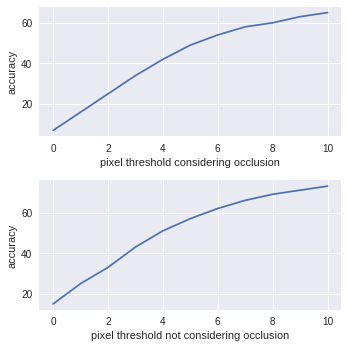

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
plt.subplot(2, 1, 1)
plt.plot(l, h) 
plt.xlabel('pixel threshold considering occlusion')
plt.ylabel('accuracy')
plt.subplot(2, 1, 2)
plt.plot(l1, h1) 
plt.xlabel('pixel threshold not considering occlusion')
plt.ylabel('accuracy')
plt.tight_layout()
plt.savefig('./error_comparision.png')
plt.show()

In [0]:
print pm1
torch.cuda.empty_cache() 

[]


In [0]:
import pickle
res = pickle.load(open("./persondata1.pkl","rb"))

In [6]:
print res

Output hidden; open in https://colab.research.google.com to view.